In [1]:
%%javascript
$('.nbp-app-bar').toggle()

<IPython.core.display.Javascript object>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Read in the Dataset

In [3]:
path = '../kaggle_data/input/'
readings = pd.read_csv(path+'train.csv')

In [4]:
# How large is our training dataset?
print(readings.shape) 
readings.columns 

(10506, 12)


Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'WnvPresent'],
      dtype='object')

In [5]:
# Individual daily trap readings are combination of date, trap, and species. Readings with > 50 mosquitos are split.
subset=readings[['NumMosquitos','Date', 'Trap', 'Species', 'WnvPresent']]
subset.groupby(['Date', 'Trap', 'Species']).sum().sort_values(['WnvPresent'], ascending=False).head()

NumMosquitos  WnvPresent
Date       Trap Species                                         
2007-08-16 T115 CULEX PIPIENS                   2532          10
2013-08-01 T900 CULEX PIPIENS/RESTUANS           984           9
2013-08-29 T900 CULEX PIPIENS                    281           8
2007-08-22 T115 CULEX PIPIENS                   1554           7
           T138 CULEX PIPIENS                   1054           6

## Outcome Variable

In [6]:
# Rename the outcome variable
readings.rename(columns={'WnvPresent':'Virus'}, inplace=True)

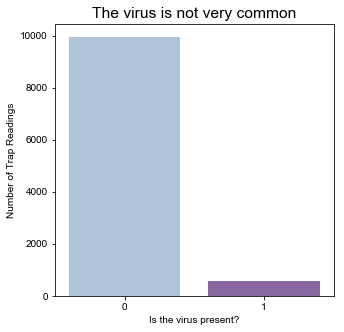

In [7]:
# It is highly imbalanced.
ax=plt.figure(figsize=(5,5))
ax=sns.countplot(readings['Virus'], palette='BuPu');
sns.set(style="white", context="talk")
ax.set(title='The virus is not very common', ylabel='Number of Trap Readings', xlabel='Is the virus present?');

## Organize the `date` variable

In [8]:
# Let's convert date/time into something usable. 
readings['Day']=readings['Date'].str.split('-').str[-1].astype(str)
readings['Month']=readings['Date'].str.split('-').str[1].astype(str)
readings['Year']=readings['Date'].str.split('-').str[0].astype(int)
readings['MonthDay']=readings['Month'].astype(str) + readings['Day'].astype(str)
readings[['Date', 'Year', 'Month','Day', 'MonthDay']].head()

,Date,Year,Month,Day,MonthDay
0,2007-05-29,2007,05,29,0529
1,2007-05-29,2007,05,29,0529
2,2007-05-29,2007,05,29,0529
3,2007-05-29,2007,05,29,0529
4,2007-05-29,2007,05,29,0529


In [9]:
# Let's create a running count of days within the year:
readings['DayRunner']=pd.to_datetime(readings['Date']).dt.dayofyear
print(readings['DayRunner'].describe())
readings[['DayRunner', 'MonthDay', 'Month', 'Day']].head()

count    10506.000000
mean       217.941938
std         31.735797
min        148.000000
25%        196.000000
50%        217.000000
75%        241.000000
max        282.000000
Name: DayRunner, dtype: float64


,DayRunner,MonthDay,Month,Day
0,149,0529,05,29
1,149,0529,05,29
2,149,0529,05,29
3,149,0529,05,29
4,149,0529,05,29


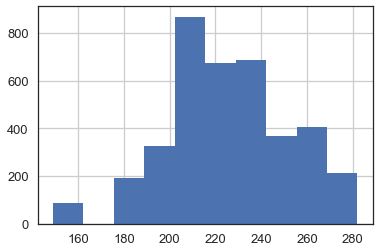

In [10]:
# Let's visualize that dayrunner variable for just one year (2007)
readings[readings['Year']==2007]['DayRunner'].hist();

In [11]:
# How many months are there? Six, ranging from May to October.
readings['Month']=readings['Month'].astype(int)
readings['Month'].value_counts().sort_index()

5       84
6     1571
7     2606
8     3751
9     2218
10     276
Name: Month, dtype: int64

In [12]:
# How many years are we talking about? Just 4 of them.
readings['Year'].value_counts()

2007    3811
2013    2392
2009    2249
2011    2054
Name: Year, dtype: int64

In [13]:
# Is the virus about the same across the four years?
x=readings['Virus'].groupby(readings['Year']).value_counts()
print(x)

Year  Virus
2007  0        3575
      1         236
2009  0        2230
      1          19
2011  0        1997
      1          57
2013  0        2153
      1         239
Name: Virus, dtype: int64


In [14]:
# Drop the variables we no longer need
readings.columns
readings=readings.drop(['Day', 'MonthDay'], axis=1)

## Species

In [15]:
## Species of Mosquito
readings['Species'].value_counts()

CULEX PIPIENS/RESTUANS    4752
CULEX RESTUANS            2740
CULEX PIPIENS             2699
CULEX TERRITANS            222
CULEX SALINARIUS            86
CULEX TARSALIS               6
CULEX ERRATICUS              1
Name: Species, dtype: int64

In [16]:
# Reduce this categorical variable to just 4 categories
readings['CULEX']='ALTER'
readings.loc[(readings['Species']=='CULEX PIPIENS/RESTUANS') , 'CULEX']='PIPIENS-RESTUANS'
readings.loc[(readings['Species']=='CULEX RESTUANS') , 'CULEX']='RESTUANS'
readings.loc[(readings['Species']=='CULEX PIPIENS') , 'CULEX']='PIPIENS'
readings['CULEX'].value_counts()

PIPIENS-RESTUANS    4752
RESTUANS            2740
PIPIENS             2699
ALTER                315
Name: CULEX, dtype: int64

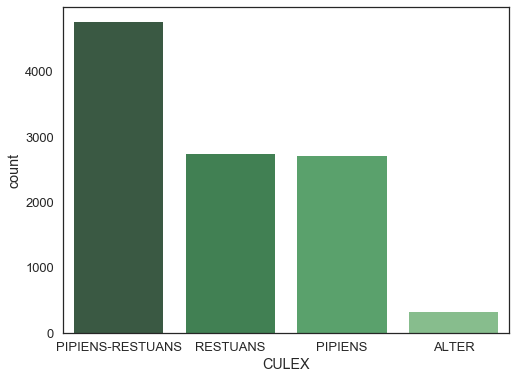

In [17]:
# Pipiens and Restuans are the most common species.
sns.set(style="white", context="talk")
ax=plt.figure(figsize=(8,6))
ax=sns.countplot(readings['CULEX'], palette="Greens_d")

In [18]:
# Convert those 4 categories into dummy variables for modeling later on.
dummies=pd.get_dummies(readings['CULEX'])
readings=pd.concat([readings, dummies], axis=1)

## Lat and Long

In [19]:
# Any missing values?
print(readings['Latitude'].isnull().sum())
print(readings['Longitude'].isnull().sum())

0
0


In [20]:
# Let's take a look at these to make sure there are no weird values or outliers.
print(readings['Latitude'].describe())
print(readings['Longitude'].describe())

count    10506.000000
mean        41.841139
std          0.112742
min         41.644612
25%         41.732984
50%         41.846283
75%         41.954690
max         42.017430
Name: Latitude, dtype: float64
count    10506.000000
mean       -87.699908
std          0.096514
min        -87.930995
25%        -87.760070
50%        -87.694991
75%        -87.627796
max        -87.531635
Name: Longitude, dtype: float64


In [21]:
# Convert lat-long into a single variable
readings['lat_long'] = list(zip(readings['Latitude'], readings['Longitude']))
readings.head(1)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,Virus,Month,Year,DayRunner,CULEX,ALTER,PIPIENS,PIPIENS-RESTUANS,RESTUANS,lat_long
0,2007-05-29,"4100 North Oak Park Avenue, Chicago, IL 60634,...",CULEX PIPIENS/RESTUANS,41,N OAK PARK AVE,T002,"4100 N OAK PARK AVE, Chicago, IL",41.95469,-87.800991,9,...,0,5,2007,149,PIPIENS-RESTUANS,0,0,1,0,"(41.95469, -87.800991)"


## Mapping Hot Spots where the Virus is more frequent

In [22]:
readings.columns

Index(['Date', 'Address', 'Species', 'Block', 'Street', 'Trap',
       'AddressNumberAndStreet', 'Latitude', 'Longitude', 'AddressAccuracy',
       'NumMosquitos', 'Virus', 'Month', 'Year', 'DayRunner', 'CULEX', 'ALTER',
       'PIPIENS', 'PIPIENS-RESTUANS', 'RESTUANS', 'lat_long'],
      dtype='object')

In [23]:
# First we need to group the trap readings so we get a more accurate basis for how often the virus is present.
# Note that we are collapsing TWO variables here: trap readings with plus-50 mosquitos, and with multiple species.
shortlist=readings.drop(['Address', 'Species', 'Block', 'Street', 'AddressNumberAndStreet',
                         'Latitude', 'Longitude', 'AddressAccuracy','Month', 
                        'Year', 'DayRunner', 'ALTER','PIPIENS', 'PIPIENS-RESTUANS', 'RESTUANS'], axis=1)
max_virus=shortlist.groupby(['Date','Trap']).max().reset_index().drop(['NumMosquitos'], axis=1)
print(max_virus.shape)
print(readings.shape) # This shows we've reduced our dataset by about 50%.
max_virus.head(2)

(4616, 5)
(10506, 21)


,Date,Trap,Virus,CULEX,lat_long
0,2007-05-29,T002,0,RESTUANS,"(41.95469, -87.800991)"
1,2007-05-29,T007,0,RESTUANS,"(41.994991, -87.769279)"


0.08340554592720971


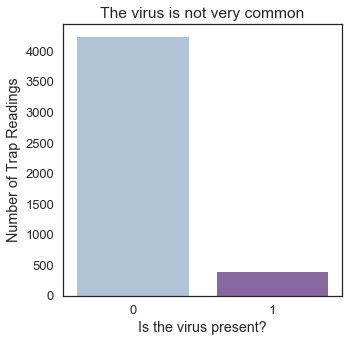

In [48]:
# It is highly imbalanced.
print(max_virus['Virus'].mean())
ax=plt.figure(figsize=(5,5))
ax=sns.countplot(max_virus['Virus'], palette='BuPu');
sns.set(style="white", context="talk")
ax.set(title='The virus is not very common', ylabel='Number of Trap Readings', xlabel='Is the virus present?');

In [25]:
# How many of all the lat-long combinations have ever tested positive for the virus?
latlongs=max_virus.groupby('lat_long').mean().reset_index()
print(len(latlongs)) # There are 138 unique lat/longs.
latlongs.head()

138


,lat_long,Virus
0,"(41.644612, -87.604498)",0.111111
1,"(41.659112, -87.538693)",0.120000
2,"(41.662014, -87.724608)",0.075758
3,"(41.673408, -87.599862)",0.166667
4,"(41.678618, -87.559308)",0.023810


In [26]:
# What are the 5 worst spots in the city?
latlongs.sort_values(by=['Virus'], ascending=False).head(5)

,lat_long,Virus
119,"(41.974689, -87.890615)",0.370370
10,"(41.702724, -87.536497)",0.333333
8,"(41.688324, -87.676709)",0.263158
29,"(41.743402, -87.731435)",0.243902
23,"(41.731922, -87.677512)",0.235294


#### Where's that spot with 37% probability of the virus? because I do NOT want to live near there.

In [27]:
readings[readings['lat_long']==(41.974689, -87.890615)].head(1)

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,Virus,Month,Year,DayRunner,CULEX,ALTER,PIPIENS,PIPIENS-RESTUANS,RESTUANS,lat_long
3868,2009-05-28,"ORD Terminal 5, O'Hare International Airport, ...",CULEX RESTUANS,10,W OHARE AIRPORT,T900,"1000 W OHARE AIRPORT, Chicago, IL",41.974689,-87.890615,9,...,0,5,2009,148,RESTUANS,0,0,0,1,"(41.974689, -87.890615)"


Oh, it's just the airport. Remember to bring some OFF! next time I have a connecting flight.
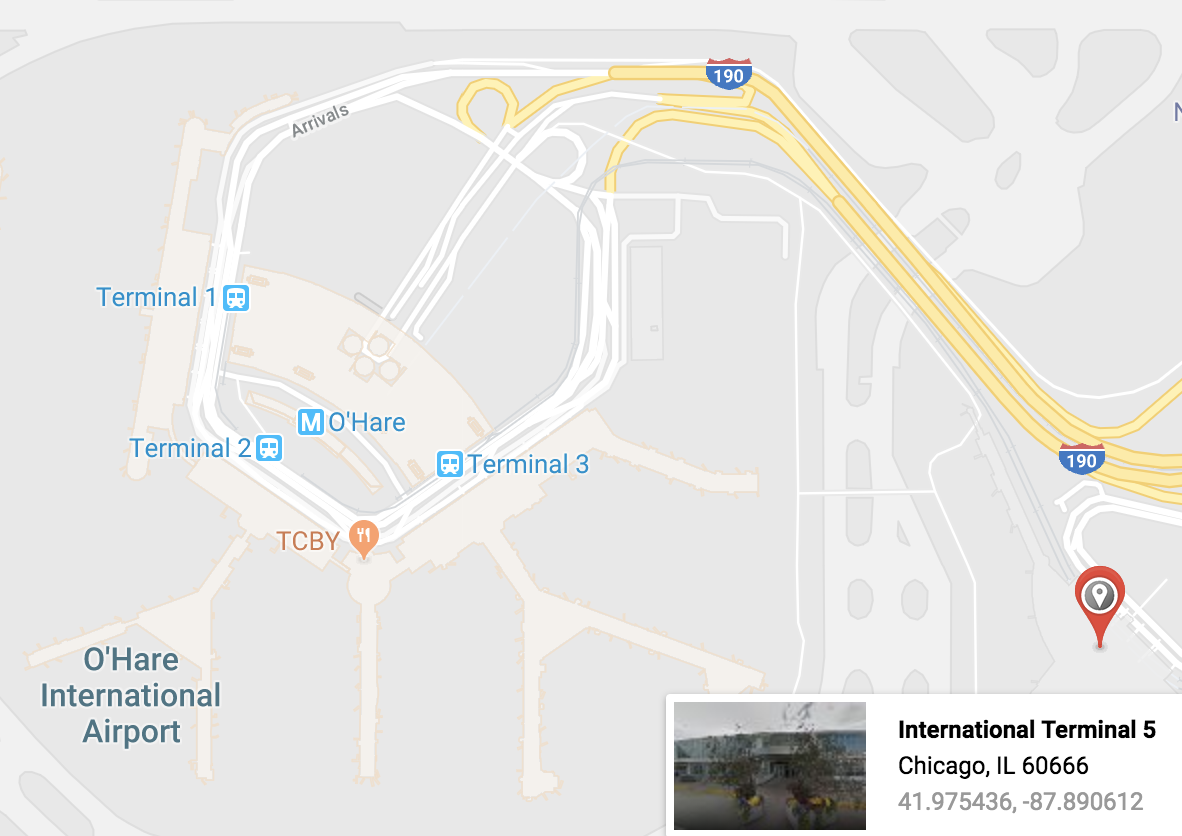

In [28]:
# Certain lat-longs have the virus more frequently. 
top30 = latlongs.sort_values(by=['Virus'], ascending=False).head(30)
top_hots=list(top30['lat_long']) # Save this list for later use.
top_hots
import pickle

with open('top_hots.pickle', 'wb') as f:
    pickle.dump(top_hots, f, protocol=0)

count    138.000000
mean       0.075626
std        0.074515
min        0.000000
25%        0.000000
50%        0.065574
75%        0.117392
max        0.370370
Name: Virus, dtype: float64


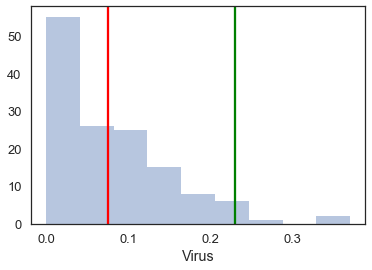

In [29]:
# What's the distribution of those lat-longs? Only 5 are higher than the green line (.23)
print(latlongs['Virus'].describe())

ax=sns.distplot(latlongs['Virus'], kde=False);
plt.axvline(x=latlongs[  'Virus'].mean(), color='red');
plt.axvline(x=.23, color='green');

## Distance from Spots with a High Virus Frequency

In [30]:
# Here's how to calculate distance in Python:
from geopy.distance import vincenty
newport_ri = (41.49008, -71.312796)
cleveland_oh = (41.499498, -81.695391)
print(vincenty(newport_ri, cleveland_oh).miles)

538.3904451566326


In [31]:
# For each trap, let's calculate its distance from the top virus hotspots
hot_list=[]
for x in range(30):
    digit=str(x)
    readings['to_hotspot'+digit]=readings['lat_long'].apply(lambda row: vincenty(row, top_hots[x]).miles)
    
    # Create an indicator if a row is less than 1 mile from one of the virus hotspots
    readings['flag_hotspot'+digit]=readings['to_hotspot'+digit].apply(lambda row: row<1).astype(int)
    hot_list.append('flag_hotspot'+digit)

# Summarize those indicators.
readings['near_hotspot'] = readings[hot_list].sum(axis=1)
readings['near_hotspot'].describe()

count    10506.000000
mean         0.544641
std          0.704886
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          4.000000
Name: near_hotspot, dtype: float64

In [32]:
# Did this do what we wanted it to? Let's check out that max.
readings[readings['near_hotspot']==4].head(1)
# It's located NEAR O'Hare airport, but also near 3 other hotspots.

,Date,Address,Species,Block,Street,Trap,AddressNumberAndStreet,Latitude,Longitude,AddressAccuracy,...,flag_hotspot25,to_hotspot26,flag_hotspot26,to_hotspot27,flag_hotspot27,to_hotspot28,flag_hotspot28,to_hotspot29,flag_hotspot29,near_hotspot
50,2007-06-05,"9100 West Higgins Avenue, Chicago, IL 60656, USA",CULEX RESTUANS,91,W HIGGINS AVE,T009,"9100 W HIGGINS AVE, Chicago, IL",41.981964,-87.812827,8,...,0,2.556767,0,15.117775,0,21.180922,0,14.247395,0,4


## Mapping Distance from Spots with a High Number of Mosquitos

In [33]:
# First we need to group the trap readings so we get a more accurate basis for how often the virus is present.
# Note that we are collapsing TWO variables here: trap readings with plus-50 mosquitos, and with multiple species.
# shortlist=readings.drop(['Address', 'Species', 'Block', 'Street', 'AddressNumberAndStreet',
#                          'Latitude', 'Longitude', 'AddressAccuracy','Month', 
#                         'Year', 'DayRunner', 'ALTER','PIPIENS', 'PIPIENS-RESTUANS', 'RESTUANS'], axis=1)
max_virus=shortlist.groupby(['Date','Trap']).max().reset_index().drop(['NumMosquitos'], axis=1)
print(max_virus.shape)
print(readings.shape) # This shows we've reduced our dataset by about 50%.
max_virus.head(2)

(4616, 5)
(10506, 82)


,Date,Trap,Virus,CULEX,lat_long
0,2007-05-29,T002,0,RESTUANS,"(41.95469, -87.800991)"
1,2007-05-29,T007,0,RESTUANS,"(41.994991, -87.769279)"


In [34]:
shortlist.columns

Index(['Date', 'Trap', 'NumMosquitos', 'Virus', 'CULEX', 'lat_long'], dtype='object')

In [35]:
# Let's repeat the same process we used for chomps hotspots, only using "mean" instead of "max".
max_chomps=shortlist.groupby(['Date',
                              'Trap']).agg({'NumMosquitos':'mean', 
                                                   'lat_long':'max'}).reindex_axis(['NumMosquitos',
                                                                                    'lat_long'], axis=1).reset_index()
print(max_chomps.shape)
max_chomps.head(2)

(4616, 4)


,Date,Trap,NumMosquitos,lat_long
0,2007-05-29,T002,1.0,"(41.95469, -87.800991)"
1,2007-05-29,T007,1.0,"(41.994991, -87.769279)"


In [36]:
latlongs=max_chomps.groupby('lat_long').mean().reset_index()
# What are the 5 worst spots in the city for getting a mosquito bite?
latlongs.sort_values(by=['NumMosquitos'], ascending=False).head(5)

,lat_long,NumMosquitos
10,"(41.702724, -87.536497)",30.956187
3,"(41.673408, -87.599862)",21.446723
119,"(41.974689, -87.890615)",17.722358
107,"(41.95469, -87.800991)",15.372992
133,"(42.008314, -87.777921)",15.275000


#### It's near a place called "Big Marsh Park." Go figure.
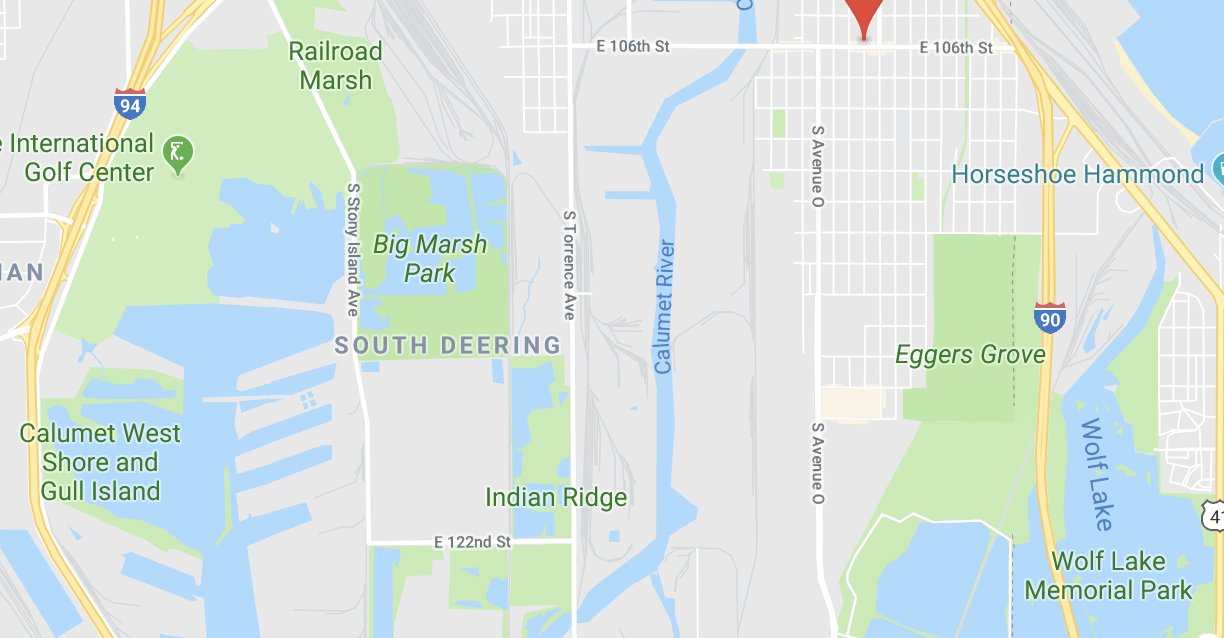

In [37]:
# Make a list of the top 30 spots to get bitten.
top30=latlongs.sort_values(by='NumMosquitos', ascending=False).head(30)
top_chomps=list(top30['lat_long']) # Save this list for later use.
with open('top_chomps.pickle', 'wb') as f:
    pickle.dump(top_chomps, f, protocol=0)

In [38]:
# Do the same thing for its distance from the spots with highest average mosquito count.
chomp_list=[]
for x in range(30):
    digit=str(x)
    readings['to_chompspot'+digit]=readings['lat_long'].apply(lambda row: vincenty(row, top_chomps[x]).miles)   

    # Create an indicator if a row is less than 2 miles from one of the high-mosquito-count chompspots
    readings['flag_chompspot'+digit]=readings['to_chompspot'+digit].apply(lambda row: row<2).astype(int)
    chomp_list.append('flag_chompspot'+digit)

readings['near_chompspot'] = readings[chomp_list].sum(axis=1)
readings['near_chompspot'].describe()

count    10506.000000
mean         1.406815
std          1.133089
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
Name: near_chompspot, dtype: float64

In [39]:
# Create a "drop" list of (nearly) all the variables we just created 
drop_list=[]
for x in range(30):
    digit=str(x)
    drop_list.append('to_hotspot'+digit)
    drop_list.append('flag_hotspot'+digit)
    drop_list.append('to_chompspot'+digit)
    drop_list.append('flag_chompspot'+digit)
# Drop them because they are no longer necessary.
readings=readings.drop(hot_list + chomp_list + drop_list, axis=1)

## Export to csv

In [40]:
# Drop a few columns that are just clutter now.
readings2=readings.drop(['Trap', 'Species', 'Address', 'Block', 'Street', 'AddressNumberAndStreet',
       'Latitude', 'Longitude', 'AddressAccuracy', 'NumMosquitos', 'lat_long'], axis=1)

In [41]:
# Check the columns that are left.
readings2.columns

Index(['Date', 'Virus', 'Month', 'Year', 'DayRunner', 'CULEX', 'ALTER',
       'PIPIENS', 'PIPIENS-RESTUANS', 'RESTUANS', 'near_hotspot',
       'near_chompspot'],
      dtype='object')

In [42]:
readings2.head(2)

,Date,Virus,Month,Year,DayRunner,CULEX,ALTER,PIPIENS,PIPIENS-RESTUANS,RESTUANS,near_hotspot,near_chompspot
0,2007-05-29,0,5,2007,149,PIPIENS-RESTUANS,0,0,1,0,1,4
1,2007-05-29,0,5,2007,149,RESTUANS,0,0,0,1,1,4


In [43]:
# Save the cleaned, engineered data
dirname = '../Austin/'
readings.to_csv(dirname + 'readings2.csv', index=False)

## Map of all Traps, by Virus Present

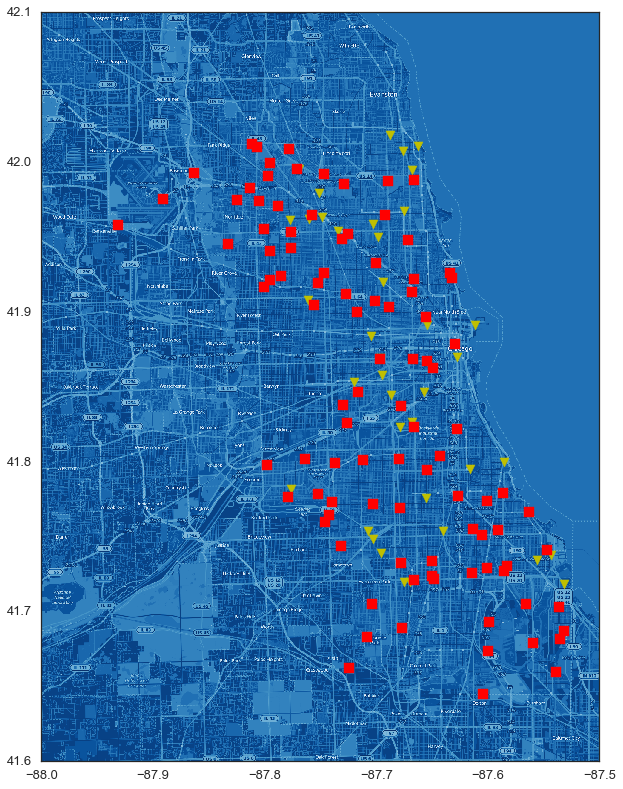

In [44]:
mapdata = np.loadtxt("../kaggle_data/maps/mapdata_copyright_openstreetmap_contributors.txt")
traps = pd.read_csv('../kaggle_data/input/train.csv')[['Date', 'Longitude', 'Latitude', 'WnvPresent']]

aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('Blues'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = traps[['Longitude', 'Latitude']].drop_duplicates().values

locations_with_virus = traps[traps.WnvPresent==1][['Longitude', 'Latitude']].drop_duplicates().values

plt.scatter(locations[:,0], locations[:,1], marker='v', c='y')
plt.scatter(locations_with_virus[:,0], locations_with_virus[:,1], marker=',', c='r')
plt.legend()

## Map of Traps near Virus Hotspots

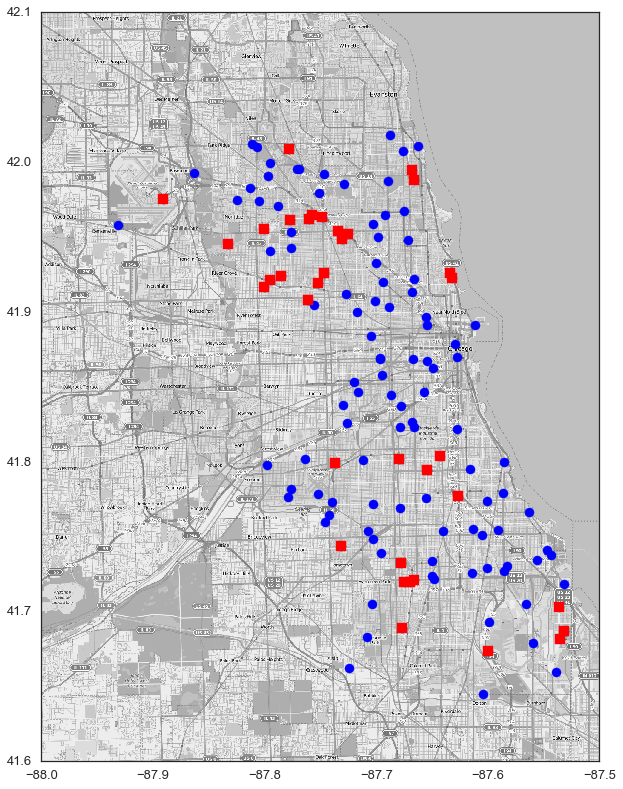

In [45]:
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = readings[['Longitude', 'Latitude']].drop_duplicates().values

locations_with_virus = readings[readings.near_hotspot==1][['Longitude', 'Latitude']].drop_duplicates().values

plt.scatter(locations[:,0], locations[:,1], marker='o', c='b')
plt.scatter(locations_with_virus[:,0], locations_with_virus[:,1], marker=',', c='r')

## Map of Traps near Spots with High Mosquito Counts

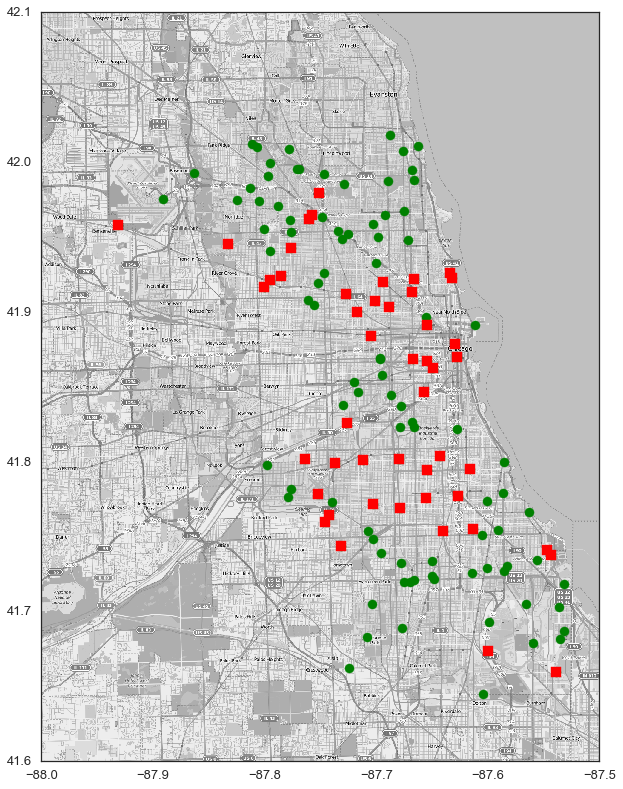

In [46]:
aspect = mapdata.shape[0] * 1.0 / mapdata.shape[1]
lon_lat_box = (-88, -87.5, 41.6, 42.1)

plt.figure(figsize=(10,14))
plt.imshow(mapdata, 
           cmap=plt.get_cmap('gray'), 
           extent=lon_lat_box, 
           aspect=aspect)

locations = readings[['Longitude', 'Latitude']].drop_duplicates().values

locations_with_virus = readings[readings.near_chompspot==1][['Longitude', 'Latitude']].drop_duplicates().values

plt.scatter(locations[:,0], locations[:,1], marker='o', c='g')
plt.scatter(locations_with_virus[:,0], locations_with_virus[:,1], marker=',', c='r')